# Exercise 1

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.

In [141]:
# Pydata stack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)

from random import randint
from time import perf_counter  # To measure performance

from sklearn.base import BaseEstimator

# scikit-learn
from sklearn.datasets import fetch_openml  # For open source ML sets
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score
)
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import set_config  # Displays HTML representation of composite estimators
set_config(display="diagram")

## Look at the Big Picture

**Goal:** Classifier with 97% *accuracy*.

## Get The Data

In [2]:
mnist = fetch_openml("mnist_784", version=1)

# load data into dataframes
X, y = mnist["data"], mnist["target"]

# use predefined train/test split
X_train, X_test, y_train, y_test = (
    X.iloc[:6000],
    X.iloc[6000:],
    y.iloc[:6000],
    y.iloc[6000:],
)

## Discover and Visualise

Pick a digit to visualise.

Digit label: 0


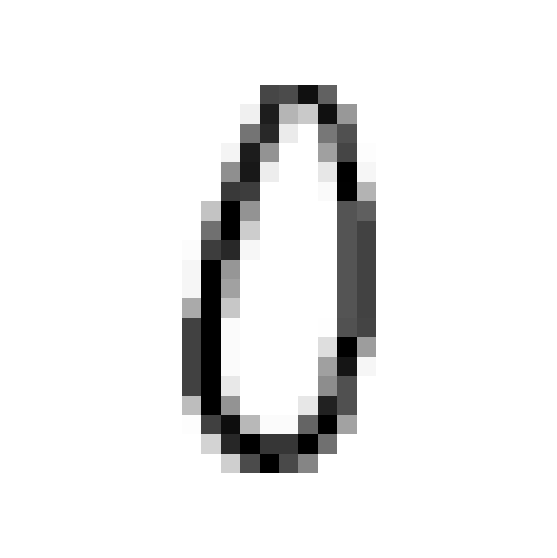

In [3]:
# Generate random index and print label
num_samples = X_train.shape[0]
example_ix = randint(0, num_samples - 1)
print("Digit label: {}".format(y.iloc[example_ix]))

# Get pixel data and put in correct shape
example_digit = X.iloc[example_ix]
example_digit = example_digit.values  # Want underlying Numpy array
example_digit_image = example_digit.reshape(28, 28)

# Show image
plt.imshow(example_digit_image, cmap="binary")
plt.axis("off");

Is the dataset skewed?

In [4]:
class_counts = y_train.value_counts().sort_index()
class_pcts = 100 * class_counts / num_samples
class_pcts.round(1)

0     9.9
1    11.2
2     9.7
3    10.1
4    10.4
5     8.6
6    10.1
7    10.8
8     9.2
9    10.0
Name: class, dtype: float64

Different classes are essentially balanced.

## Prepare the Data

### Missing Values

In [5]:
# total missing values
X_train.isnull().sum().sum()

0

### Feature Scaling

In [6]:
# distribution of mean pixel values
X_train.mean().describe()

count    784.000000
mean      33.525455
std       42.747944
min        0.000000
25%        0.106917
50%        7.397833
75%       69.591583
max      140.767333
dtype: float64

In [7]:
# distribution of variances amoung pixel values
X_train.var().describe()

count      784.000000
mean      4383.413493
std       4994.377315
min          0.000000
25%         16.434569
50%       1434.667600
75%      10254.960547
max      12970.111982
dtype: float64

Features have widely different scales. Use standardisation (Min-Max is too sensitive to outliers).

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

### Full Pipeline

Put full pipeline together.

In [9]:
full_pipeline = make_pipeline(StandardScaler())
X_train_prep = full_pipeline.fit_transform(X_train)

## Select and Train Model

Start with K-Neighbors using default hyperparameter values.

In [20]:
knc_clf = KNeighborsClassifier()
cv_score = cross_val_score(knc_clf, X_train_prep, y_train, cv=5, scoring="accuracy")
print("Mean Accuracy: {:.2f}".format(cv_score.mean()))

Mean Accuracy: 0.89


## Fine-Tuning

### Grid Search for Hyperparameters

In [23]:
# available hyperparameters
knc_clf = KNeighborsClassifier()
knc_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [29]:
# hyperparams to try
param_grid = [
    {"n_neighbors": [1, 3, 10, 30, 100], "weights": ["uniform", "distance"]}
]

# Initialise grid search
grid_search = GridSearchCV(
    knc_clf,
    param_grid,
    scoring="accuracy",
    cv=5,
    return_train_score=True,
    refit=True,
)

# Fit and time how long it takes
start_time = perf_counter()
grid_search.fit(X_train_prep, y_train)
end_time = perf_counter()
print("Grid search run time: {:0.1f} seconds".format(end_time - start_time))

Grid search run time: 40.9 seconds


In [31]:
# full results
cv_results = grid_search.cv_results_
cv_results

{'mean_fit_time': array([0.01720653, 0.01723337, 0.01733341, 0.01680522, 0.01741118,
        0.01734185, 0.0171895 , 0.01666284, 0.01643329, 0.01654186]),
 'std_fit_time': array([0.00207175, 0.00058674, 0.00067542, 0.00057293, 0.00119615,
        0.00145147, 0.0006023 , 0.00070345, 0.00050385, 0.0003647 ]),
 'mean_score_time': array([0.1217926 , 0.11159801, 0.15638499, 0.1242085 , 0.18745236,
        0.1824791 , 0.21681318, 0.16291842, 0.2051208 , 0.17248592]),
 'std_score_time': array([0.00672851, 0.00841808, 0.00765515, 0.00143594, 0.00289927,
        0.00708854, 0.01554093, 0.00278527, 0.01612239, 0.00324724]),
 'param_n_neighbors': masked_array(data=[1, 1, 3, 3, 10, 10, 30, 30, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                    'uniform', 'distance', 'uniform'

In [40]:
def generate_grid_search_cv_summary(cv_results):
    cv_summary = pd.DataFrame(cv_results['params'])
    cv_summary["mean_train_score"] = cv_results["mean_train_score"].round(3)
    cv_summary["mean_test_score"] = cv_results["mean_test_score"].round(3)
    cv_summary = cv_summary.sort_values(by="mean_test_score", ascending=False)
    
    return cv_summary


cv_summary = generate_grid_search_cv_summary(cv_results)
cv_summary

,n_neighbors,weights,mean_train_score,mean_test_score
3,3,distance,1.000,0.897
2,3,uniform,0.949,0.893
0,1,uniform,1.000,0.891
1,1,distance,1.000,0.891
5,10,distance,1.000,0.891
4,10,uniform,0.915,0.887
7,30,distance,1.000,0.870
6,30,uniform,0.879,0.867
9,100,distance,1.000,0.805
8,100,uniform,0.807,0.796


There seems to be a lot of overfitting going on, particularly with 'distance' weights.

Possible solutions to over-fitting:
- Simplify model (possibly by applying regularisation)
- Gather more data
- Reduce noise in training data

From the docs:
- "in general a larger $k$ suppresses the effects of noise, but makes the classification boundaries less distinct"
- Weights:
    - "the value assigned to a query point is computed from a simple majority vote of the nearest neighbors"
    - "`weights = 'distance'` assigns weights proportional to the inverse of the distance from the query point"

I don't understand why distance weights has 100% accuracy regardless of the value of $k$ - increasing this should reduce overfitting. I'm going to try higher values of $k$.

In [39]:
# hyperparams to try
param_grid = [
    {"n_neighbors": [100, 300, 1000], "weights": ["distance"]}
]

# Initialise grid search
grid_search = GridSearchCV(
    knc_clf,
    param_grid,
    scoring="accuracy",
    cv=5,
    return_train_score=True,
    refit=True,
)

# Fit and time how long it takes
start_time = perf_counter()
grid_search.fit(X_train_prep, y_train)
end_time = perf_counter()
print("Grid search run time: {:0.1f} seconds".format(end_time - start_time))

Grid search run time: 19.4 seconds


In [41]:
cv_results = grid_search.cv_results_
cv_summary = generate_grid_search_cv_summary(cv_results)
cv_summary

,n_neighbors,weights,mean_train_score,mean_test_score
0,100,distance,1.0,0.805
1,300,distance,1.0,0.675
2,1000,distance,1.0,0.439


Again, mean train score is always 1. 

I don't thinking training error is actually a useful metric here. We are weighting the importance of points by their distance. If a point in the training set is evaluated, it will be weighted very highly and so the algorithm will always give that label as its prediction. I think it's better to just look at test error.

Based on the first set, it looks like $k$ between 1 and 10 is best.

In [43]:
# hyperparams to try
param_grid = [
    {"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], "weights": ["uniform", "distance"]}
]

# Initialise grid search
grid_search = GridSearchCV(
    knc_clf,
    param_grid,
    scoring="accuracy",
    cv=5,
    return_train_score=True,
    refit=True,
)

# Fit and time how long it takes
start_time = perf_counter()
grid_search.fit(X_train_prep, y_train)
end_time = perf_counter()
print("Grid search run time: {:0.1f} seconds".format(end_time - start_time))

Grid search run time: 82.6 seconds


In [44]:
cv_results = grid_search.cv_results_
cv_summary = generate_grid_search_cv_summary(cv_results)
cv_summary

,n_neighbors,weights,mean_train_score,mean_test_score
11,6,distance,1.000,0.903
7,4,distance,1.000,0.901
9,5,distance,1.000,0.899
5,3,distance,1.000,0.897
15,8,distance,1.000,0.896
13,7,distance,1.000,0.896
8,5,uniform,0.933,0.895
4,3,uniform,0.949,0.893
10,6,uniform,0.927,0.892
6,4,uniform,0.938,0.892


There is a bit of improvement, but it seems that test score it plateaued around 0.9.

In [48]:
# get the best estimator
knc_clf = grid_search.best_estimator_
knc_clf

KNeighborsClassifier(n_neighbors=6, weights='distance')

Best estimator has $k$=6 and distance weights.

### Error Analysis

Let's use the confusion matrix to see where we're going wrong.

In [49]:
y_train_pred = cross_val_predict(knc_clf, X_train_prep, y_train, cv=5)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[583,   1,   0,   1,   0,   3,   1,   1,   2,   0],
       [  0, 661,   3,   2,   2,   0,   0,   0,   2,   1],
       [  6,  26, 484,  22,   4,   1,  11,  14,  12,   1],
       [  4,   6,  10, 551,   1,  10,   1,   8,  11,   6],
       [  0,  21,   9,   0, 540,   6,   3,   2,   1,  41],
       [  5,   6,   1,  20,   6, 444,  10,   1,  13,   8],
       [ 10,   3,   4,   0,   4,   8, 578,   0,   1,   0],
       [  0,  16,   2,   1,  13,   0,   1, 564,   0,  54],
       [  9,  15,   5,  16,   4,  16,   5,   2, 473,   6],
       [  4,   2,   4,   6,  14,   1,   1,  29,   3, 537]])

In [54]:
# noramlise to get error rates
row_sums = conf_mx.sum(axis=1)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
norm_conf_mx.round(3)

array([[0.   , 0.001, 0.   , 0.002, 0.   , 0.006, 0.002, 0.002, 0.004,
        0.   ],
       [0.   , 0.   , 0.005, 0.003, 0.003, 0.   , 0.   , 0.   , 0.004,
        0.002],
       [0.01 , 0.039, 0.   , 0.036, 0.006, 0.002, 0.018, 0.022, 0.022,
        0.002],
       [0.007, 0.009, 0.017, 0.   , 0.002, 0.019, 0.002, 0.012, 0.02 ,
        0.01 ],
       [0.   , 0.031, 0.015, 0.   , 0.   , 0.012, 0.005, 0.003, 0.002,
        0.068],
       [0.008, 0.009, 0.002, 0.033, 0.01 , 0.   , 0.016, 0.002, 0.024,
        0.013],
       [0.017, 0.004, 0.007, 0.   , 0.006, 0.016, 0.   , 0.   , 0.002,
        0.   ],
       [0.   , 0.024, 0.003, 0.002, 0.021, 0.   , 0.002, 0.   , 0.   ,
        0.09 ],
       [0.015, 0.022, 0.009, 0.026, 0.006, 0.031, 0.008, 0.003, 0.   ,
        0.01 ],
       [0.007, 0.003, 0.007, 0.01 , 0.022, 0.002, 0.002, 0.045, 0.005,
        0.   ]])

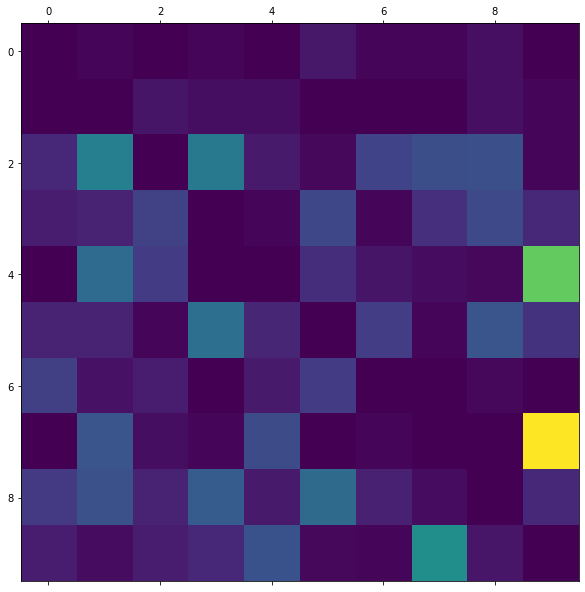

In [55]:
plt.matshow(norm_conf_mx);

It looks like a lot of 4s and 7s are being classified as 9s.

In [60]:
# accuracy for each class
diag = [conf_mx[i, i] for i in range(conf_mx.shape[0])]
row_sums = conf_mx.sum(axis=1)
class_acc = diag / row_sums
class_acc.round(3)

array([0.985, 0.985, 0.833, 0.906, 0.867, 0.864, 0.951, 0.866, 0.858,
       0.894])

There are some specific problem classes.

Possible next steps:
- Remove 'problem samples'
    - E.g. it's possible that samples that are easily confused are having an undue effect
- Feature reduction/removal

### Removing Samples

How to identify problem samples?

The KNN classifier supplies prediction probabilities. One possibility is to remove those where the values are ambiguous.

I think it's best to use leave-on-out cross-validation here. It's the best way to accurately gauge the performance on 'new' data.

In [69]:
kf = KFold(n_splits=num_samples) # to force non-stratified cross-validation

# Fit and time how long it takes
start_time = perf_counter()
knc_scores = cross_val_predict(knc_clf, X_train_prep, y_train, cv=kf, method="predict_proba")
end_time = perf_counter()
print("Predict time: {:0.1f} seconds".format(end_time - start_time))

Predict time: 129.9 seconds


In [78]:
knc_scores[:10, :]

array([[0.15473276, 0.        , 0.        , 0.67893901, 0.        ,
        0.16632823, 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.51088539,
        0.        , 0.        , 0.16378802, 0.        , 0.32532659],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

The predictions are simply the class with the greatest probability.

In [81]:
np.argmax(knc_scores[:10, :], axis=1)

array([3, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [80]:
np.max(knc_scores[:10, :], axis=1)

array([0.67893901, 1.        , 0.51088539, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

For 8 of these, the algorithm is certain, for two is isn't. What is the distribution here?

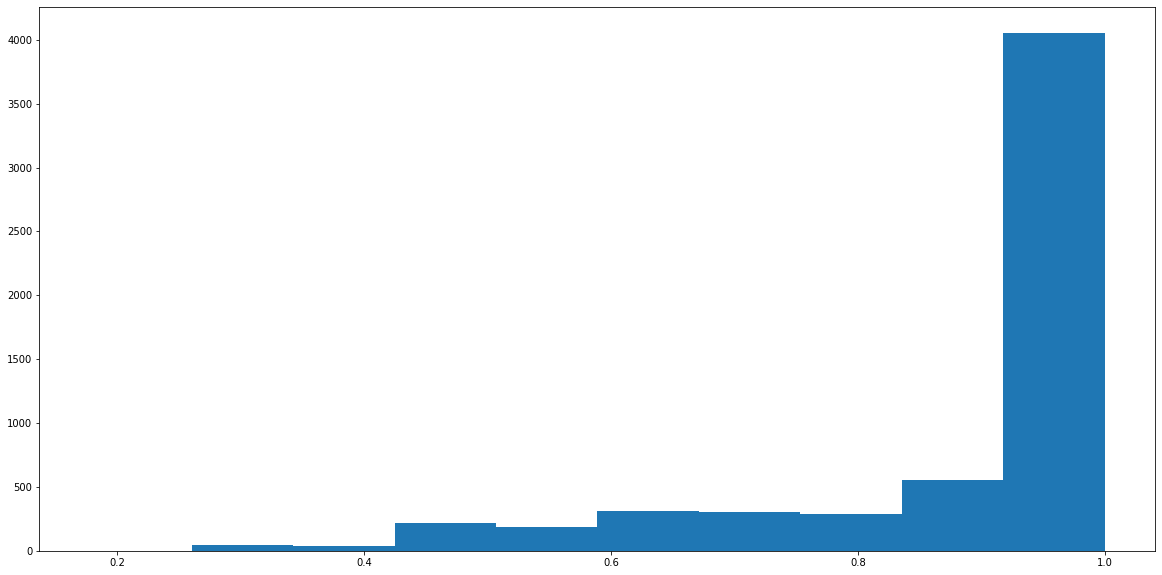

In [84]:
max_probs = np.max(knc_scores, axis=1)

fig, ax = plt.subplots()
ax.hist(max_probs);

In [86]:
(max_probs == 1).sum() / num_samples

0.6755

So 67.5% of the predictions are certain.

In [85]:
(max_probs >= 0.8).sum() / num_samples

0.814

81% of the samples have over 80% certainty.

Let's plot what proportion of samples have max probability above x.

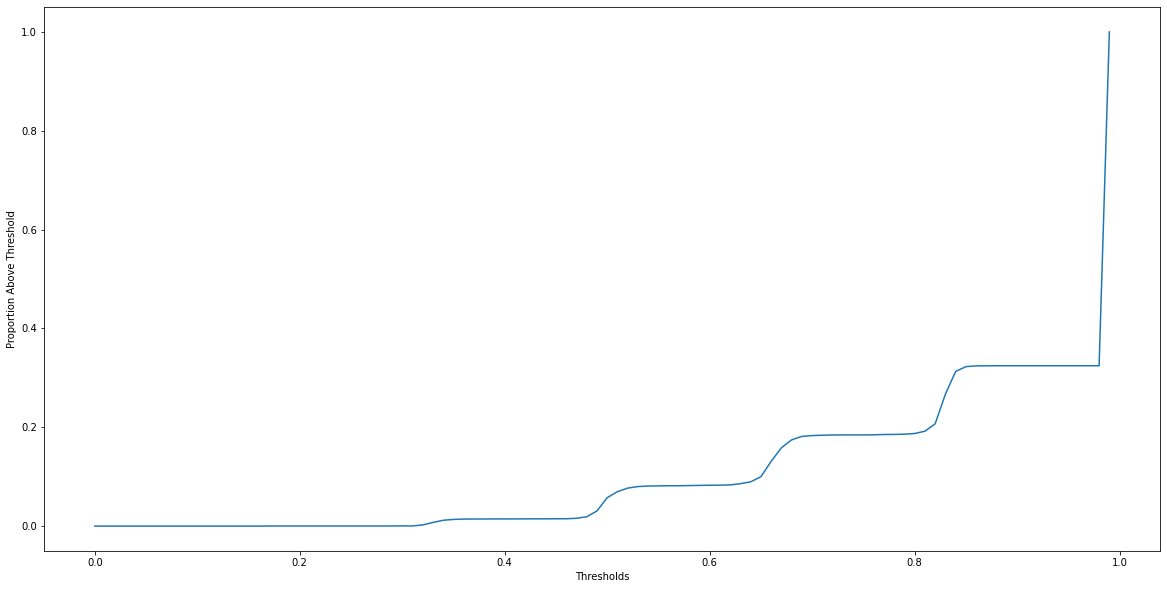

In [127]:
def plot_proportions_above_thresholds(max_probs, bins=100):
    # bin according to how many points lie between 2 thresholds
    hist, bin_edges = np.histogram(max_probs, bins=bins, range=(0, 1))
    
    # cumulative sum for how many above threshold
    hist_cum = np.cumsum(hist)
    
    # normalise
    hist_cum_norm = hist_cum / len(max_probs)
    
    fig, ax = plt.subplots()
    
    plt.plot(bin_edges[:-1], hist_cum_norm)
    
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Proportion Above Threshold')
    
    results = 100 * np.c_[bin_edges[:-1], hist_cum_norm].round(3)
    
    return results


results = plot_proportions_above_thresholds(max_probs, bins=100)
ax = plt.gca();

Why does it jump like that?

In [128]:
results

array([[  0. ,   0. ],
       [  1. ,   0. ],
       [  2. ,   0. ],
       [  3. ,   0. ],
       [  4. ,   0. ],
       [  5. ,   0. ],
       [  6. ,   0. ],
       [  7. ,   0. ],
       [  8. ,   0. ],
       [  9. ,   0. ],
       [ 10. ,   0. ],
       [ 11. ,   0. ],
       [ 12. ,   0. ],
       [ 13. ,   0. ],
       [ 14. ,   0. ],
       [ 15. ,   0. ],
       [ 16. ,   0. ],
       [ 17. ,   0. ],
       [ 18. ,   0. ],
       [ 19. ,   0. ],
       [ 20. ,   0. ],
       [ 21. ,   0. ],
       [ 22. ,   0. ],
       [ 23. ,   0. ],
       [ 24. ,   0. ],
       [ 25. ,   0. ],
       [ 26. ,   0. ],
       [ 27. ,   0. ],
       [ 28. ,   0. ],
       [ 29. ,   0. ],
       [ 30. ,   0. ],
       [ 31. ,   0. ],
       [ 32. ,   0.2],
       [ 33. ,   0.7],
       [ 34. ,   1.2],
       [ 35. ,   1.4],
       [ 36. ,   1.4],
       [ 37. ,   1.4],
       [ 38. ,   1.4],
       [ 39. ,   1.4],
       [ 40. ,   1.4],
       [ 41. ,   1.4],
       [ 42. ,   1.5],
       [ 43

Plan: Train on only those samples which have prediction probability > 75%

In [144]:
X_train_prep_red = X_train_prep[(max_probs >= 0.75)]
y_train_red = y_train[(max_probs >= 0.75)]

X_train_prep_excl = X_train_prep[(max_probs < 0.75)]
y_train_excl = y_train[(max_probs < 0.75)]

In [135]:
# Is the sample still balanced?
class_counts = y_train_red.value_counts().sort_index()
class_pcts = 100 * class_counts / num_samples
class_pcts.round(1)

0     9.4
1    11.0
2     6.9
3     8.0
4     8.0
5     6.2
6     9.3
7     8.4
8     6.6
9     7.7
Name: class, dtype: float64

#### Testing

In [134]:
# hyperparams to try
param_grid = [
    {"n_neighbors": [3, 4, 5, 6, 7], "weights": ["uniform", "distance"]}
]

# Initialise grid search
grid_search = GridSearchCV(
    knc_clf,
    param_grid,
    scoring="accuracy",
    cv=5,
    return_train_score=True,
    refit=True,
)

# Fit and time how long it takes
start_time = perf_counter()
grid_search.fit(X_train_prep_red, y_train_red)
end_time = perf_counter()
print("Grid search run time: {:0.1f} seconds".format(end_time - start_time))

Grid search run time: 24.1 seconds


Note that this is only training and testing on the 'easy samples'

In [136]:
cv_results = grid_search.cv_results_
cv_summary = generate_grid_search_cv_summary(cv_results)
cv_summary

,n_neighbors,weights,mean_train_score,mean_test_score
1,3,distance,1.000,0.964
0,3,uniform,0.971,0.963
3,4,distance,1.000,0.963
7,6,distance,1.000,0.961
2,4,uniform,0.969,0.960
5,5,distance,1.000,0.960
4,5,uniform,0.966,0.959
9,7,distance,1.000,0.956
6,6,uniform,0.965,0.955
8,7,uniform,0.964,0.955


This improved performance a lot. But how will it now perform on the excluded samples?

In [137]:
knc_clf = grid_search.best_estimator_
knc_clf

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [147]:
y_train_excl_pred = knc_clf.predict(X_train_prep_excl)
accuracy_score(y_train_excl, y_train_excl_pred)

0.5537488708220416

This does extremely badly on the excluded samples.

I guess that we removed the most ambiguous samples, so it now doesn't know how to deal with those examples.

#### Reflection

This approach didn't work at all. I think that the idea of removing particularly ambiguous images (for example those that a human couldn't classify) is valuable, but this approach to selecting them just removes all that are even a little ambiguous. Not only does this remove a lot more for particular classes, it also means that the model has never seen an ambiguous image before.

#### Another Attempt

What if we try this again for a different threshold.

In [155]:
# get reduced data
threshold = 0.4

X_train_prep_red = X_train_prep[(max_probs >= threshold)]
y_train_red = y_train[(max_probs >= threshold)]
num_samples_red = len(y_train_red)

X_train_prep_excl = X_train_prep[(max_probs < threshold)]
y_train_excl = y_train[(max_probs < threshold)]
num_samples_excl = len(y_train_excl)

# just choose some reasonable hyperparams
knc_clf = KNeighborsClassifier(n_neighbors=5, weights="distance")

# Do cross validation
cv_scores = cross_val_score(
    knc_clf,
    X_train_prep_red,
    y_train_red,
    scoring="accuracy",
    cv=5
)
mean_red_score = cv_scores.mean()
print("Mean CV Accuracy: {:.2f}".format(mean_red_score))

# now test on excluded samples
knc_clf.fit(X_train_prep_red, y_train_red)
y_train_excl_pred = knc_clf.predict(X_train_prep_excl)
excl_score = accuracy_score(y_train_excl, y_train_excl_pred)
print("Excl. Accuracy: {:.2f}".format(excl_score))

weighted_avg_score = (mean_red_score * num_samples_red + excl_score * num_samples_excl) / num_samples
print("Weighted Avg. Accuracy: {:.2f}".format(weighted_avg_score))

Mean CV Accuracy: 0.91
Excl. Accuracy: 0.33
Weighted Avg. Accuracy: 0.90


So there is no improvement overall.